In [31]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.utils import shuffle

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

from tqdm.notebook import tqdm
    
%matplotlib inline

from PIL import Image
import shutil


In [32]:
#BASE_DIR = '//kaggle/input/utk-face-cropped/utkcropped' #Kaggle
BASE_DIR = 'UTKFace'
filepath = os.path.join(BASE_DIR, 'UTKFace.tar.gz')
!tar -xzvf $filepath -C $BASE_DIR
!rm $filepath

filepath = os.path.join(BASE_DIR, 'crop_part1.tar.gz')
!tar -xzvf $filepath -C $BASE_DIR
!mv  /content/drive/MyDrive/selected_dataset/crop_part1/* /content/drive/MyDrive/selected_dataset/UTKFace/
!rm $filepath
!rm -r /content/drive/MyDrive/selected_dataset/crop_part1/

In [33]:
def age_to_class( age ):
  age_class = None
  # 0 (0-20)
  if 0 <= age <= 20:
    age_class = 0
  # 1 (20-40)
  if 20 < age <= 40:
    age_class = 1
  # 2 (40-60)
  if 40 < age <= 60:
    age_class = 2
  # 3 (40-60)
  if 60 < age <= 80:
    age_class = 3
  # 3 (80+)
  if age > 80:
    age_class = 4
  return age_class

# map age classes for age gaps
age_dict = {0:'0-20', 1:'20-40',2:'40-60', 3:'60-80', 4:'80+'}

def decode_age_label(age_id):
  return age_dict[int(age_id)]



In [34]:
# read labels of image age, gender
image_paths = []
age_labels = []
gender_labels =[]
age_class = []
names = []

for filename in tqdm(os.listdir(BASE_DIR)):
  #read image path
    try:  
      image_path = os.path.join(BASE_DIR, filename)
      #split filename to extract labels
      temp= filename.split('_')
      age = int(temp[0])
      gender = int(temp[1])
      image_paths.append(image_path)
      age_labels.append(age)
      gender_labels.append(gender)
      names.append(filename)
      age_class.append(age_to_class(age))
    except:
        continue



#convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['age_class'], df['name'] = image_paths, age_labels, gender_labels, age_class, names
df.head()
df


  0%|          | 0/23710 [00:00<?, ?it/s]

,image,age,gender,age_class,name
0,//kaggle/input/utk-face-cropped/utkcropped/26_...,26,0,1,26_0_2_20170104023102422.jpg.chip.jpg
1,//kaggle/input/utk-face-cropped/utkcropped/22_...,22,1,1,22_1_1_20170112233644761.jpg.chip.jpg
2,//kaggle/input/utk-face-cropped/utkcropped/21_...,21,1,1,21_1_3_20170105003215901.jpg.chip.jpg
3,//kaggle/input/utk-face-cropped/utkcropped/28_...,28,0,1,28_0_0_20170117180555824.jpg.chip.jpg
4,//kaggle/input/utk-face-cropped/utkcropped/17_...,17,1,0,17_1_4_20170103222931966.jpg.chip.jpg
...,...,...,...,...,...
23704,//kaggle/input/utk-face-cropped/utkcropped/41_...,41,0,2,41_0_0_20170109012220690.jpg.chip.jpg
23705,//kaggle/input/utk-face-cropped/utkcropped/42_...,42,0,2,42_0_0_20170117185738076.jpg.chip.jpg
23706,//kaggle/input/utk-face-cropped/utkcropped/2_0...,2,0,0,2_0_2_20161219221701671.jpg.chip.jpg
23707,//kaggle/input/utk-face-cropped/utkcropped/65_...,65,1,3,65_1_0_20170110182002744.jpg.chip.jpg


<AxesSubplot:xlabel='age', ylabel='Density'>

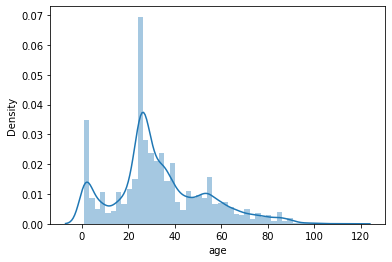

In [35]:
sns.distplot(df["age"])


In [36]:
def extract_features (images):
  features=[]
  for image in tqdm(images):
    img = imread(image, as_gray=True)
    resized_img = resize(img, (128,64)) 
    #creating hog features 
    fd = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=False, multichannel=False)
    
    features.append(fd)

  features=np.array(features)
  # features=features.reshape(len(features),128,128,1)
  return features

In [37]:
if not os.path.isfile('data.csv'):
    X= extract_features(df['image'])
    dff= pd.DataFrame(X)
    data = pd.concat([df,dff],axis=1)
    data.to_csv('data.csv', index=False)
else:
    data=pd.read_csv('data.csv')
data

,image,age,gender,age_class,name,0,1,2,3,4,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
0,//kaggle/input/utk-face-cropped/utkcropped/26_...,26,0,1,26_0_2_20170104023102422.jpg.chip.jpg,0.391481,0.391481,0.001955,0.008894,0.031587,...,0.348812,0.348812,0.222906,0.014065,0.063917,0.097048,0.083695,0.186172,0.348812,0.214039
1,//kaggle/input/utk-face-cropped/utkcropped/22_...,22,1,1,22_1_1_20170112233644761.jpg.chip.jpg,0.340575,0.004567,0.003305,0.001744,0.011760,...,0.325095,0.264366,0.237794,0.020858,0.032721,0.184560,0.045691,0.055270,0.215477,0.192752
2,//kaggle/input/utk-face-cropped/utkcropped/21_...,21,1,1,21_1_3_20170105003215901.jpg.chip.jpg,0.065806,0.108254,0.212946,0.070780,0.059132,...,0.061372,0.427087,0.000000,0.000000,0.000000,0.163287,0.000000,0.000000,0.045377,0.427087
3,//kaggle/input/utk-face-cropped/utkcropped/28_...,28,0,1,28_0_0_20170117180555824.jpg.chip.jpg,0.322549,0.079419,0.048414,0.060055,0.069887,...,0.109180,0.020396,0.039041,0.037401,0.009699,0.042759,0.018221,0.002477,0.009778,0.005490
4,//kaggle/input/utk-face-cropped/utkcropped/17_...,17,1,0,17_1_4_20170103222931966.jpg.chip.jpg,0.387188,0.387188,0.071568,0.000000,0.107328,...,0.424778,0.111392,0.028812,0.010847,0.007042,0.030175,0.003019,0.004604,0.032276,0.097143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23704,//kaggle/input/utk-face-cropped/utkcropped/41_...,41,0,2,41_0_0_20170109012220690.jpg.chip.jpg,0.382422,0.002020,0.000000,0.000000,0.025981,...,0.022427,0.113370,0.023716,0.000000,0.097684,0.433393,0.092044,0.011426,0.031588,0.019210
23705,//kaggle/input/utk-face-cropped/utkcropped/42_...,42,0,2,42_0_0_20170117185738076.jpg.chip.jpg,0.404747,0.350921,0.000000,0.001599,0.032951,...,0.152971,0.068308,0.003930,0.002988,0.000000,0.036369,0.007620,0.009923,0.023872,0.087534
23706,//kaggle/input/utk-face-cropped/utkcropped/2_0...,2,0,0,2_0_2_20161219221701671.jpg.chip.jpg,0.312613,0.036544,0.018528,0.010794,0.141580,...,0.034622,0.460821,0.023041,0.000000,0.000000,0.027292,0.003536,0.000000,0.012414,0.460821
23707,//kaggle/input/utk-face-cropped/utkcropped/65_...,65,1,3,65_1_0_20170110182002744.jpg.chip.jpg,0.271191,0.336741,0.161215,0.056852,0.101747,...,0.361136,0.153320,0.000000,0.000000,0.000000,0.016464,0.000000,0.000600,0.004217,0.389163


In [38]:
from sklearn.utils import shuffle
data = shuffle(data)


X= data.iloc[:,5:]
Y_age= np.array(data['age_class'][:])
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, Y_age, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

print("Training examples", X_train.shape[0])
print("Validation examples", X_val.shape[0])
print("Testing examples", X_test.shape[0])

Training examples 15173
Validation examples 3794
Testing examples 4742


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3780)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              15486976  
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              1678

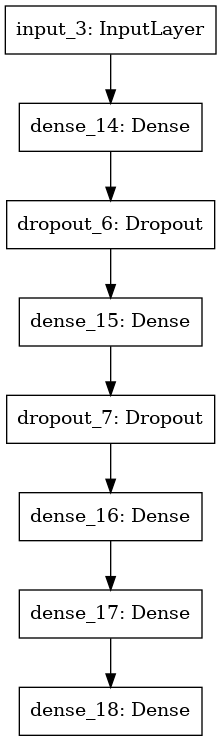

In [39]:
from pathlib import Path
path = Path("./models")
path.mkdir(exist_ok=True)


MODEL_PATH = "./models/age_best_model.h5"


checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, 
                                                monitor='val_sparse_categorical_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')
inputs = Input(shape=(3780,))

x = Dense(4096 ,kernel_regularizer='l2',activation='relu')(inputs)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096,kernel_regularizer='l2', activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096,kernel_regularizer='l2', activation='relu')(x)
x = Dense(4096, activation='relu')(x)

prediction = Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()
tf.keras.utils.plot_model( model , to_file='architecture.png')

In [10]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint]
                    )

2022-12-19 20:19:45.324998: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 458831520 exceeds 10% of free system memory.
2022-12-19 20:19:45.855512: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 458831520 exceeds 10% of free system memory.
2022-12-19 20:19:46.240696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
947/949 [============================>.] - ETA: 0s - loss: 14.4454 - sparse_categorical_accuracy: 0.6348

2022-12-19 20:19:59.695376: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114730560 exceeds 10% of free system memory.
2022-12-19 20:19:59.820866: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114730560 exceeds 10% of free system memory.


949/949 [==============================] - 15s 14ms/step - loss: 14.4274 - sparse_categorical_accuracy: 0.6349 - val_loss: 1.4584 - val_sparse_categorical_accuracy: 0.6492

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.64918, saving model to ./models/age_best_model.h5
Epoch 2/20
949/949 [==============================] - 13s 14ms/step - loss: 1.1625 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.7090

Epoch 00002: val_sparse_categorical_accuracy improved from 0.64918 to 0.70901, saving model to ./models/age_best_model.h5
Epoch 3/20
949/949 [==============================] - 13s 14ms/step - loss: 0.9620 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.9506 - val_sparse_categorical_accuracy: 0.6848

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.70901
Epoch 4/20
949/949 [==============================] - 13s 13ms/step - loss: 0.8881 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.8573 - val_

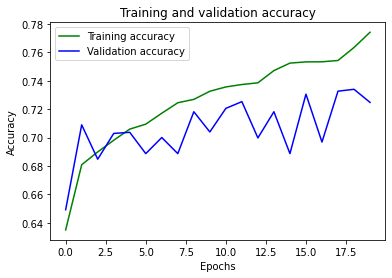

In [11]:
accuracy_direct = history.history['sparse_categorical_accuracy']
accuracy_val_direct = history.history['val_sparse_categorical_accuracy']
epochs = range(20)
plt.plot(epochs, accuracy_direct, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val_direct, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test) 
pred_classes = [x.argmax() for x in y_pred]
cm = confusion_matrix(y_test, pred_classes)

print ("Accuracy : ", accuracy_score(y_test, pred_classes))
print(cm)
print(classification_report(y_test, pred_classes))

2022-12-19 20:24:23.886699: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 143398080 exceeds 10% of free system memory.


Accuracy :  0.742724588781105
[[ 694  223    9    2    1]
 [  90 2205  158    9    0]
 [  11  351  433   83    3]
 [   2   36  150  151   19]
 [   2    5   16   50   39]]
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       929
           1       0.78      0.90      0.83      2462
           2       0.57      0.49      0.53       881
           3       0.51      0.42      0.46       358
           4       0.63      0.35      0.45       112

    accuracy                           0.74      4742
   macro avg       0.67      0.58      0.61      4742
weighted avg       0.73      0.74      0.73      4742



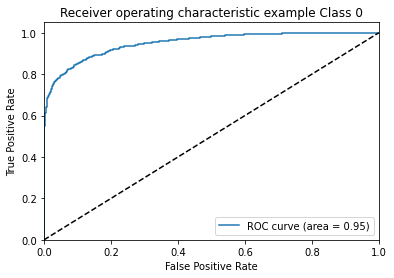

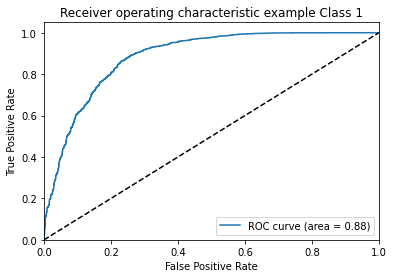

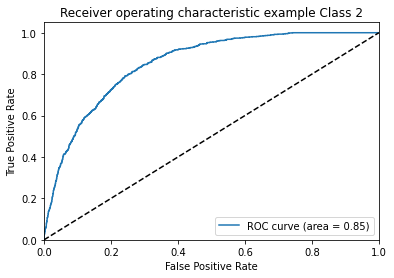

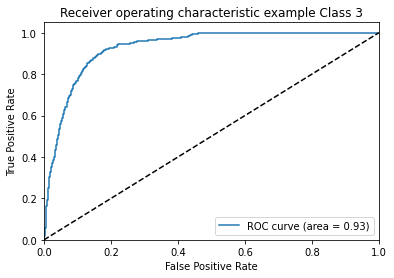

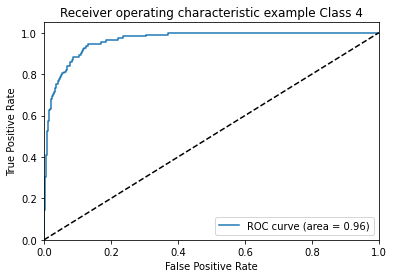

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
y = label_binarize(y_test, classes=[0,1,2,3,4])
n_classes = 5

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic example Class {i}')
    plt.legend(loc="lower right")
    plt.show()

# CNN Code

In [23]:
df = data.iloc[:,:5]

training_data = df.sample(frac=0.8, random_state=25)
temp = df.drop(training_data.index)


val_data =  temp.sample(frac=0.7, random_state=25)
testing_data = temp.drop(val_data.index)

 
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of training examples: {val_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 18967
No. of training examples: 3319
No. of testing examples: 1423


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)


CLASS_MODE = 'raw'
BATCH_SIZE = 16
IMAGE_SIZE= [224,224]
train_generator = train_datagen.flow_from_dataframe(dataframe=training_data, 
                                                directory=BASE_DIR, 
                                                x_col='name', 
                                                y_col='age', 
                                                class_mode=CLASS_MODE,
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True, 
                                                target_size=IMAGE_SIZE)



val_generator = val_datagen.flow_from_dataframe(dataframe=val_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)

test_generator = val_datagen.flow_from_dataframe(dataframe=testing_data, 
                                              directory=BASE_DIR, 
                                              x_col='name', 
                                              y_col='age', 
                                              class_mode=CLASS_MODE, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              target_size=IMAGE_SIZE)



In [ ]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

vgg.inputs

In [ ]:
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(4096,kernel_regularizer='l2' ,activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096,kernel_regularizer='l2', activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)

prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()
tf.keras.utils.plot_model( model , to_file='architecture.png' )


In [ ]:
# all layers before are locked
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
x = Dense(4096 ,activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)
x = Dense(4096,kernel_regularizer='l2', activation='relu')(x)
# x = Dense(4096, activation='relu')(x)

prediction = Dense(1,activation='linear')(x)
model = Model(inputs=vgg.input, outputs=prediction)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics='mae')

# model.summary()
tf.keras.utils.plot_model( model , to_file='architecture.png' )


In [ ]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks = [checkpoint]
                    )

In [ ]:
accuracy_direct = history.history['mae']
accuracy_val_direct = history.history['val_mae']
epochs = range(20)
plt.plot(epochs, accuracy_direct, 'g', label='Training MAE')
plt.plot(epochs, accuracy_val_direct, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()
